In [1]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
import pickle as pkl
from random import sample 
from Final_Data_Prep import get_train_test
from Final_Data_Prep import downsample

The notebook is adapted from Training the final model.ipynb, which was used in the original project. 

Below are the changes we have made to the original notebook:

1) Reading the data in from a pickle rather than csv. This pickle was created by Data_Prep.ipynb Jan 28, 2020 during an effort by Kelsey Markey and Alene Rhea to host this project on GitHub. It's possible that there are inconsistencies between the data read in from csv in the original notebook, and from the data read in via pickle. This question could be investigated, because the original csv still exists in the project Google Drive.

2) Not dropping date and location columns, as this step was moved to Data_Prep.ipynb in January 2020.

2) Using Final_Data_Prep.py for splitting and downsampling. This script was created in January 2020. All functionality is identical, although some print statements have been removed and dead/unreachable code has been deleted.

3) Updating comments.

In [2]:
final_df = pd.read_pickle('total_df.pckl.gz', compression = 'gzip')

#fix missing values in weekday, latitude, longitude
final_df['weekday'] = final_df['weekday'].fillna(final_df['weekday'].median())
final_df['latitude'] = final_df['latitude'].fillna(final_df['latitude'].median()) 
final_df['longitude'] = final_df['longitude'].fillna(final_df['longitude'].median()) 

#put earliest 85% of cases into training df, latest 15% of cases into test df
training_df, test_df = get_train_test(final_df, 0.85, 0.15)

# passing 50 to downsample function means training set will have 50% positive cases
training_df = downsample(training_df, 50)

X_train = training_df.drop('MHI', axis=1)
y_train = training_df['MHI']

X_test = test_df.drop('MHI', axis=1)
y_test = test_df['MHI']

In [3]:
clf = GradientBoostingClassifier(random_state=42, max_depth = 3, 
                                 min_samples_leaf = 10, learning_rate=.01, 
                                 n_estimators=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
AUC = auc(fpr, tpr)
recall = metrics.recall_score(y_test, y_pred)

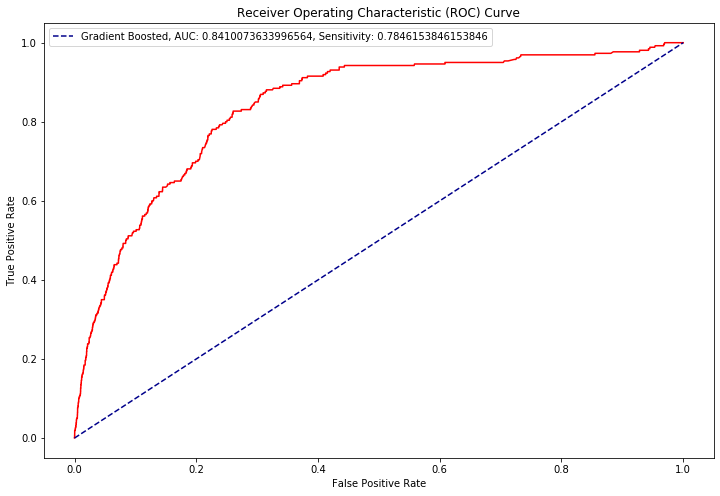

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', 
         label='Gradient Boosted, AUC: {}, Sensitivity: {}'.format(AUC, recall))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [6]:
print('Recall: ', recall)
print('AUC: ', AUC)
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Number of positive cases predicted: ', np.sum(y_pred))
print('Actual number of positive cases in test set: ', np.sum(y_test))
print('Predicted prevalence: ', np.sum(y_pred)/len(y_pred))
print('Actual prevalence in test set: ', np.sum(y_test)/len(y_test))

Recall:  0.7846153846153846
AUC:  0.8410073633996564
Accuracy:  0.7656296842930609
Number of positive cases predicted:  10311
Actual number of positive cases in test set:  260
Predicted prevalence:  0.2377833636971612
Actual prevalence in test set:  0.0059958951179577055


We see some differences in these measures as compared to the original measures. In particular, the original recall was 0.761538461538, the original AUC was 0.83586007756, the original accuracy was 0.766321518345, the original number of positive cases predicted was 10269, and the original predicted prevalence was 0.23681479602426031. The measures on the actual test set are identical. This indicates that the January 2020 changes made to the data preparation process have had some effect on the model.